<a href="https://colab.research.google.com/github/balawillgetyou/dy/blob/master/streamingData2022103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Online machine learning for streaming data:  
The traditional machine learning approach is to train a model on a batch of data and then deploy it for inference. But streaming data, say from IoT devices, can change or drift over time. Such a drift could affect the distribution of independent features, P(X), without affecting their relationship to the dependent feature, y. Or, the joint probability P(X,y) could change.  
  
One way to deal with such data drift is to retrain the model either periodically or when the changes exceed some threshold. 
  
The other way to deal with this is Online Machine Learning, which just learns one record at a time. We explore this further in this notebook.  



The River package [link text](https://github.com/online-ml/river/) is one of several ways to deal with 

In [2]:
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 2.1 MB/s 


##Drift example   
This is an example with manufactured univariate data made to appear like a drift has ocurred and using the River package to detect drift.

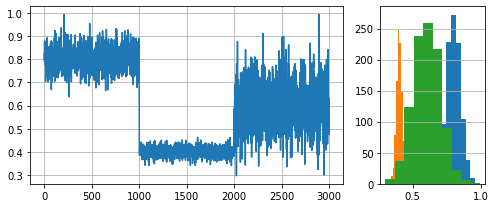

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
stream = np.concatenate((dist_a, dist_b, dist_c))

# Auxiliary function to plot the data
def plot_data(dist_a, dist_b, dist_c, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(dist_a, dist_b, dist_c)


Change detected at index 1055
Change detected at index 1087
Change detected at index 1151
Change detected at index 1183
Change detected at index 2111
Change detected at index 2143
Change detected at index 2207
Change detected at index 2335


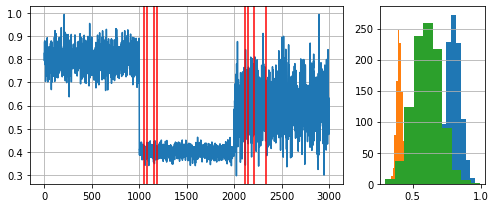

In [ ]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.change_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)

plot_data(dist_a, dist_b, dist_c, drifts)


#Online learning - regression   
We demonstrate how to learn one record at a time "online".  

In [3]:
from river import datasets

dataset = datasets.TrumpApproval()
dataset

Donald Trump approval ratings.

This dataset was obtained by reshaping the data used by FiveThirtyEight for analyzing Donald
Trump's approval ratings. It contains 5 features, which are approval ratings collected by
5 polling agencies. The target is the approval rating from FiveThirtyEight's model. The goal of
this task is to see if we can reproduce FiveThirtyEight's model.

    Name  TrumpApproval                                                              
    Task  Regression                                                                 
 Samples  1,001                                                                      
Features  6                                                                          
  Sparse  False                                                                      
    Path  /usr/local/lib/python3.7/dist-packages/river/datasets/trump_approval.csv.gz

In [11]:
#looking at a sample record
x, y = next(iter(dataset))
x

{'ordinal_date': 736389,
 'gallup': 43.843213,
 'ipsos': 46.19925042857143,
 'morning_consult': 48.318749,
 'rasmussen': 44.104692,
 'you_gov': 43.636914000000004}

In [17]:
from river import metrics

model = neighbors.KNNRegressor()#using a simple regressor

metric = metrics.MAE()

i = 0#to print performance metric at specific intervals

for x, y in dataset:
    y_pred = model.predict_one(x)#online models first make a prediction
    model.learn_one(x, y)#then, the ground truth is revealed and the learner learns from this single record
    metric.update(y, y_pred)#a metric is calculated to measure progress
    i += 1
    if i == 200:
      print(metric)
      i = 0

MAE: 0.569927
MAE: 0.429117
MAE: 0.369737
MAE: 0.337881
MAE: 0.310519


MAE: 0.310324

#Result:  
Cummulative learning is seen, in the improving MAE, as data is "streamed". Even if the data drifts, the change in the joint probability, P(X,y) is accounted for, as the model continues to learn with each record.

##Reference:  
https://riverml.xyz/dev/introduction/installation/